In [88]:
# Step 1: Import necessary libraries
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from utils.classification_data import linear_data, checkerboard_data, power_line_data, microgrid_data, make_double_cake_data
from sklearn.model_selection import train_test_split
from pennylane import numpy as np
import pennylane as qml
from pennylane import numpy as np
import matplotlib as mpl
from pennylane import numpy as np
from sklearn.cluster import SpectralClustering, KMeans
from collections import deque
import pandas as pd

#data = checkerboard_data(2)

## Extract features and target
#features = np.asarray(data.drop(columns=['target']))
#target = np.asarray(data['target'])
#target = target % 2
#target = 2 * target - 1

#X, x_test, Y, y_test = train_test_split(
#    features, target, test_size=0.2, random_state=42)

In [89]:
from sklearn.datasets import load_iris
import pandas as pd

# Load the iris dataset from sklearn
iris = load_iris()
iris_data = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_data['species'] = iris.target

# Filter for only 2 classes (species 0 and 1)
filtered_data = iris_data[iris_data['species'].isin([0, 1])]
# Create a DataFrame for easy visualization
features = np.array(filtered_data.drop(columns=['species']))
target = np.array(filtered_data['species'])
target = np.where(target == 0, -1, target)

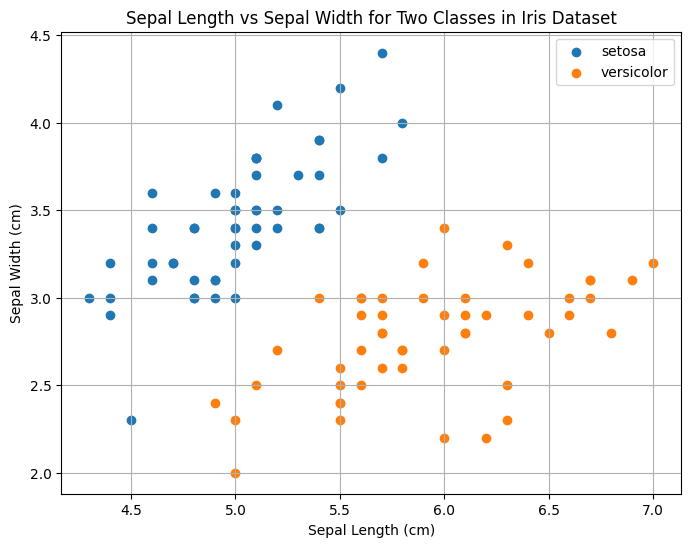

In [90]:
# Load the Iris dataset
iris = load_iris()
iris_data = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_data['species'] = iris.target

# Filter for only 2 classes (species 0 and 1)
filtered_data = iris_data[iris_data['species'].isin([0, 1])]

# Plotting Sepal Length vs Sepal Width for the two classes
plt.figure(figsize=(8, 6))
for species in [0, 1]:
    subset = filtered_data[filtered_data['species'] == species]
    plt.scatter(subset['sepal length (cm)'], subset['sepal width (cm)'], label=iris.target_names[species])

plt.title("Sepal Length vs Sepal Width for Two Classes in Iris Dataset")
plt.xlabel("Sepal Length (cm)")
plt.ylabel("Sepal Width (cm)")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [91]:
target

tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1], requires_grad=True)

In [92]:
#data = pd.read_csv('data/balanced_quantum_dataset.csv')
#features = np.asarray(data.drop(columns=['label']))
#target = np.asarray(data['label'])

X, x_test, Y, y_test = train_test_split(
    features, target, test_size=0.3, random_state=42
)

In [93]:

circuit_executions = 0
def layer(x, params, wires, i0=0, inc=1):
    """Building block of the embedding ansatz"""
    i = i0
    for j, wire in enumerate(wires):
        qml.Hadamard(wires=[wire])
        qml.RZ(x[i % len(x)], wires=[wire])
        i += inc
        qml.RY(params[0, j], wires=[wire])

    qml.broadcast(unitary=qml.CRZ, pattern="ring", wires=wires, parameters=params[1])

def ansatz(x, params, wires):
    """The embedding ansatz"""
    for j, layer_params in enumerate(params):
        layer(x, layer_params, wires, i0=j * len(wires))


adjoint_ansatz = qml.adjoint(ansatz)


def random_params(num_wires, num_layers):
    """Generate random variational parameters in the shape for the ansatz."""
    return np.random.uniform(0, 2 * np.pi, (num_layers, 2, num_wires), requires_grad=True)

dev = qml.device("default.qubit", wires=5, shots=None)
wires = dev.wires.tolist()

@qml.qnode(dev)
def kernel_circuit(x1, x2, params):
    global circuit_executions
    circuit_executions += 1
    ansatz(x1, params, wires=wires)
    adjoint_ansatz(x2, params, wires=wires)
    return qml.probs(wires=wires)

def kernel(x1, x2, params):
    return kernel_circuit(x1, x2, params)[0]


In [94]:
params = random_params(num_wires=5, num_layers=12
)

In [95]:
kernel_value = kernel(X[0], X[1], params)
print(f"The kernel value between the first and second datapoint is {kernel_value:.3f}")

The kernel value between the first and second datapoint is 0.617


In [96]:
classes = np.unique(Y)
n_clusters = 2

centroids = []
class_centroids = []
centroid_labels = []
for c in classes:
    class_data = X[np.where(Y == c)[0]]
    centroids.append(np.mean(class_data, axis=0))
    class_centroids.append([np.mean(cluster, axis=0) for cluster in np.array_split(class_data, n_clusters)])
    centroid_labels.extend([[c] * n_clusters])

In [97]:
def centroid_kernel_matrix(X, centroid, ckernel):
    
    kernel_matrix = []

    for i in range(len(X)):
        kernel_matrix.append(ckernel(centroid, X[i]))

    return np.array(kernel_matrix)

In [98]:

def centroid_target_alignment(X, Y, centroid, kernel, l = 0.1, assume_normalized_kernel=False, rescale_class_labels=True):
   
    Y = np.asarray(Y)
    K = centroid_kernel_matrix(X, centroid, kernel)
    numerator = l * np.sum(Y * K)  
    denominator = np.sqrt(np.sum(K**2) * np.sum(Y**2))

    TA = numerator / denominator

    return TA

In [99]:
def loss_kao(X, Y, centroid, kernel, params, lambda_kao = 0.01):
    TA = centroid_target_alignment(X, Y, centroid, kernel)
    r = lambda_kao * np.sum(params ** 2)
    return 1 - TA + r

In [100]:
def loss_co(X, Y, centroid, kernel, cl, lambda_kao = 0.01):
    TA = centroid_target_alignment(X, Y, centroid, kernel)
    r = np.sum(np.maximum(cl - 1, 0) - np.minimum(cl, 0))
    return 1 - TA + r

In [101]:
class1_centroids = class_centroids[0]
class2_centroids = class_centroids[1]

centroid1_labels = centroid_labels[0]
centroid2_labels = centroid_labels[1]

centroid1 = centroids[0]
centroid2 = centroids[1]

In [102]:
main_centroid = True
kao_class = 1
opt = qml.GradientDescentOptimizer(0.2)
circuit_executions = 0
params = random_params(num_wires=5, num_layers=12)
for i in range(1000):
    
    if main_centroid:
        if kao_class == 1:
            cost = lambda _params: loss_kao(
                                
                                        class1_centroids, 
                                        centroid1_labels,
                                        centroid1,
                                        lambda x1, x2: kernel(x1, x2, params),
                                        _params
                                        )
            
            centroid_cost = lambda _centroid: loss_co(
                                
                                        class1_centroids, 
                                        centroid1_labels,
                                        centroid1,
                                        lambda x1, x2: kernel(x1, x2, params),
                                        _centroid
                                        )
            kao_class = 2
        else:

            cost = lambda _params: loss_kao(
                                
                                        class2_centroids, 
                                        centroid2_labels,
                                        centroid2,
                                        lambda x1, x2: kernel(x1, x2, params),
                                        _params
                                        )
            centroid_cost = lambda _centroid: loss_co(
                                                class2_centroids, 
                                                centroid2_labels,
                                                centroid2,
                                                lambda x1, x2: kernel(x1, x2, params),
                                                _centroid
                                        )
            
            kao_class = 1
            main_centroid = False

    else:

        cost = lambda _params: -qml.kernels.target_alignment(
                                                                class1_centroids + class2_centroids,
                                                                centroid1_labels + centroid2_labels,
                                                                lambda x1, x2: kernel(x1, x2, _params),
                                                                assume_normalized_kernel=True,
                                                        )

        #if kao_class == 1:
        #    cost = lambda _params: loss_kao(
        #                        
        #                                class1_centroids, 
        #                                centroid1_labels,
        #                                centroid2,
        #                                lambda x1, x2: kernel(x1, x2, params),
        #                                _params
        #                                )
        #    
        #    centroid_cost = lambda _centroid: loss_co(
        #                        
        #                                class1_centroids, 
        #                                centroid1_labels,
        #                                centroid1,
        #                                lambda x1, x2: kernel(x1, x2, params),
        #                                _centroid
        #                                )
        #    kao_class = 2
        #else:
        #
        #    cost = lambda _params: loss_kao(
        #                        
        #                                class2_centroids, 
        #                                centroid2_labels,
        #                                centroid1,
        #                                lambda x1, x2: kernel(x1, x2, params),
        #                                _params
        #                                )
        #    centroid_cost = lambda _centroid: loss_co(
        #                                        class2_centroids, 
        #                                        centroid2_labels,
        #                                        centroid2,
        #                                        lambda x1, x2: kernel(x1, x2, params),
        #                                        _centroid
        #                                )
            
        kao_class = 1
        main_centroid = True

    #print(params)
    #print(cost(params), main_centroid, kao_class)
    params = opt.step(cost, params)

    if kao_class == 1:
        centroid1 = opt.step(centroid_cost, centroid1)
    else:
        centroid2 = opt.step(centroid_cost, centroid2)
    
    
    #if (i + 1) % 50 == 0:
print(f"Circuit Executions: {circuit_executions}") 
current_alignment = qml.kernels.target_alignment(
            X,
            Y,
            lambda x1, x2: kernel(x1, x2, params),
            assume_normalized_kernel=True,
        )
print(f"Alignment = {current_alignment:.3f}")


Circuit Executions: 5332
Alignment = 0.444


In [103]:
from sklearn.svm import SVC
# First create a kernel with the trained parameter baked into it.
trained_kernel = lambda x1, x2: kernel(x1, x2, params)

# Second create a kernel matrix function using the trained kernel.
trained_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, trained_kernel)

# Note that SVC expects the kernel argument to be a kernel matrix function.
svm_trained = SVC(kernel=trained_kernel_matrix).fit(X, Y) 

In [104]:
def accuracy(classifier, X, Y_target):
    return 1 - np.count_nonzero(classifier.predict(X) - Y_target) / len(Y_target)

In [105]:
accuracy_trained = accuracy(svm_trained, X, Y)
print(f"The accuracy of a kernel with trained parameters is {accuracy_trained:.3f}")

The accuracy of a kernel with trained parameters is 1.000


In [106]:
accuracy_trained = accuracy(svm_trained, x_test, y_test)
print(f"The accuracy of a kernel with trained {accuracy_trained}")

The accuracy of a kernel with trained 0.9666666666666667


In [107]:
circuit_executions = 0

params = random_params(num_wires=5, num_layers=12)
opt = qml.GradientDescentOptimizer(0.2)

for i in range(1000):
    # Choose subset of datapoints to compute the KTA on.
    subset = np.random.choice(list(range(len(X))), 8)
    # Define the cost function for optimization
    cost = lambda _params: -qml.kernels.target_alignment(
        X[subset],
        Y[subset],
        lambda x1, x2: kernel(x1, x2, _params),
        assume_normalized_kernel=True,
    )
    # Optimization step
    params = opt.step(cost, params)

    # Report the alignment on the full dataset every 50 steps.
print(f"Circuit Executions: {circuit_executions}")
current_alignment = qml.kernels.target_alignment(
            X,
            Y,
            lambda x1, x2: kernel(x1, x2, params),
            assume_normalized_kernel=True,
        )
print(f"Alignment = {current_alignment:.3f}")

Circuit Executions: 28000
Alignment = 0.660


In [108]:
from sklearn.svm import SVC
# First create a kernel with the trained parameter baked into it.
trained_kernel = lambda x1, x2: kernel(x1, x2, params)

# Second create a kernel matrix function using the trained kernel.
trained_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, trained_kernel)

# Note that SVC expects the kernel argument to be a kernel matrix function.
svm_trained = SVC(kernel=trained_kernel_matrix).fit(X, Y)

In [109]:
accuracy_trained = accuracy(svm_trained, X, Y)
print(f"The accuracy of a kernel with trained parameters is {accuracy_trained:.3f}")

The accuracy of a kernel with trained parameters is 1.000


In [110]:
accuracy_trained = accuracy(svm_trained, x_test, y_test)
print(f"The accuracy of a kernel with trained parameters is {accuracy_trained:.3f}")

The accuracy of a kernel with trained parameters is 1.000
